We are testing how the 3D flock shape and density change as we add more birds. In real starling flocks, researchers found that density stays roughly constant regardless of flock size, and the flock thickness grows proportionally with the cube root of volume. We want to see if our simple model can reproduce these scaling laws.

The key challenge is handling periodic boundaries correctly. When we measure the flock shape using PCA, we need to unwrap positions so the algorithm does not see the flock as split across opposite edges of the simulation box. We also scale the box size with N to the power of one third to keep things fair, otherwise larger flocks would be artificially compressed.

In [1]:
import sys
import time
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

from src.flocking_sim_3d import run_simulation
from src.geometry import unwrap_periodic, flock_volume_from_pca

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'figure.dpi': 100,
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
})

print("Setup complete")

Setup complete


PCA-based shape analysis. We compute the three principal axis lengths (think: length, width, thickness of an ellipsoid that best fits the flock). The unwrapping step is critical because periodic boundaries can make the flock appear fragmented.

In [2]:
def compute_pca_metrics(positions, box_size=1.0):
    """compute shape metrics using PCA ellipsoid approximation"""
    
    # Use centralized geometry function
    V_ellipsoid, (I1, I2, I3) = flock_volume_from_pca(positions, box_size)
    
    # Density
    N = len(positions)
    density = N / V_ellipsoid if V_ellipsoid > 0 else 0
    
    return {
        'I1': I1,
        'I2': I2,
        'I3': I3,
        'V_ellipsoid': V_ellipsoid,
        'I2_I1': I2/I1 if I1 > 0 else 0,
        'I3_I1': I3/I1 if I1 > 0 else 0,
        'density': density
    }

print("Function defined: compute_pca_metrics")

Function defined: compute_pca_metrics


In [3]:
def collect_morphology_metrics(N, align=1.5, noise=0.10, cohesion=0.5, n_seeds=5, 
                                burn_frac=0.6, steps=500, save_every=10):
    """
    Run simulations and collect morphology metrics with burn-in.
    
    Parameters
    ----------
    N : int
        Number of boids
    align : float
        Alignment strength
    noise : float
        Noise level
    cohesion : float
        Cohesion strength (explicitly set for consistency)
    """
    # Scaling: box_size ~ N^(1/3) to maintain constant density
    # This implies Volume ~ N, so Length ~ V^(1/3) ~ N^(1/3)
    box_size = N**(1.0/3.0)
    
    # Interaction radius R scales with box_size? 
    # In standard Vicsek, density Rho = N/L^3. If L ~ N^1/3, Rho is const.
    # If Rho is const, the mean inter-particle distance is const.
    # So R should be FIXED (physical units), not scaled, to maintain same 'physics'.
    # HOWEVER, previous notebook logic used R proportional to box.
    # Let's check: 
    # If R is const, N=1000 box=10 -> R=1
    # If R scales, R = 0.15 * box.
    # We stick to the user's established scaling R = 0.15 * box_size for this Scaling Analysis
    # to test Geometric Similarity (scale invariance).
    R = 0.15 * box_size
    repulsion_radius = 0.05 * box_size
    
    print(f"N={N}: box_size={box_size:.3f}, R={R:.3f}, r_rep={repulsion_radius:.3f}")
    
    metrics_list = []
    
    for seed in range(n_seeds):
        # Run simulation
        history = run_simulation(
            N=N,
            steps=steps,
            align=align,
            noise=noise,
            cohesion=cohesion,
            R=R,
            speed=0.03,
            repulsion_radius=repulsion_radius,
            repulsion_strength=1.0,
            box_size=box_size,
            seed=seed,
            save_every=save_every
        )
        
        # Burn-in: discard first 60%
        burn_idx = int(len(history) * burn_frac)
        tail_frames = history[burn_idx:]
        
        # Compute metrics for each tail frame
        for frame_idx, pos in enumerate(tail_frames):
            metrics = compute_pca_metrics(pos, box_size)
            metrics['N'] = N
            metrics['seed'] = seed
            metrics['frame'] = burn_idx + frame_idx
            metrics_list.append(metrics)
        
        print(f"  Seed {seed}: {len(tail_frames)} tail frames")
    
    return metrics_list

print("Function defined: collect_morphology_metrics")

Function defined: collect_morphology_metrics


Running simulations for N = 100, 200, 400, 800. For each size, we scale the box as N^(1/3) and adjust interaction radius proportionally. We run 5 seeds per size and discard the first 60% of frames as burn-in.

In [4]:
# Size range
N_values = [100, 200, 400, 800]

# Collect data
all_metrics = []

for N in N_values:
    print(f"\n=== N = {N} ===")
    metrics = collect_morphology_metrics(
        N=N,
        align=1.5,
        noise=0.10,
        cohesion=0.5, # Explicitly set
        n_seeds=5,
        burn_frac=0.6,
        steps=500,
        save_every=10
    )
    all_metrics.extend(metrics)

# Convert to DataFrame
df = pd.DataFrame(all_metrics)

print(f"\nTotal data points: {len(df)}")
print(f"Columns: {df.columns.tolist()}")


=== N = 100 ===
N=100: box_size=4.642, R=0.696, r_rep=0.232
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 200 ===
N=200: box_size=5.848, R=0.877, r_rep=0.292
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 400 ===
N=400: box_size=7.368, R=1.105, r_rep=0.368
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 800 ===
N=800: box_size=9.283, R=1.392, r_rep=0.464
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

Total data points: 400
Columns: ['I1', 'I2', 'I3', 'V_ellipsoid', 'I2_I1', 'I3_I1', 'density', 'N', 'seed', 'frame']


In [5]:
# Pre-calculate aggregated dataframes to fix NameError in later cells

# 1. Aggregate per seed (average over frames)
# Select only numeric columns for aggregation
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Exclude grouping keys from columns to aggregate to avoid "cannot insert" error
# 'N' and 'seed' will be the index after groupby, reset_index tries to insert them back
agg_cols = [c for c in numeric_cols if c not in ['N', 'seed']]

df_per_seed = df.groupby(['N', 'seed'])[agg_cols].mean().reset_index()

# 2. Create summary statistics per N (mean and std over seeds)
# We aggregate the metrics we just computed. 
# N is the grouper, so it won't be in columns to agg.
df_summary = df_per_seed.groupby('N')[agg_cols].agg(['mean', 'std']).reset_index()

print("Created df_per_seed and df_summary.")
print(f"df_per_seed shape: {df_per_seed.shape}")
print(f"df_summary rows: {len(df_summary)}")

Created df_per_seed and df_summary.
df_per_seed shape: (20, 10)
df_summary rows: 4


## 3. Testing Thickness Scaling

Research question: Does flock thickness grow proportionally with volume like in real bird flocks?

Cavagna et al found that real starling flocks grow in a self similar way. If we double the flock size, all dimensions should scale together. To test this, we plot thickness against the cube root of volume. If the relationship is linear, it means our model reproduces this scaling law.

We use PCA to measure the flock shape. This gives us three dimensions: length, width, and thickness. Thickness is the smallest one. We compare it to cube root of volume because that represents a characteristic size of the 3D object.

If the plot shows a straight line, our simple flocking rules produce realistic geometry.

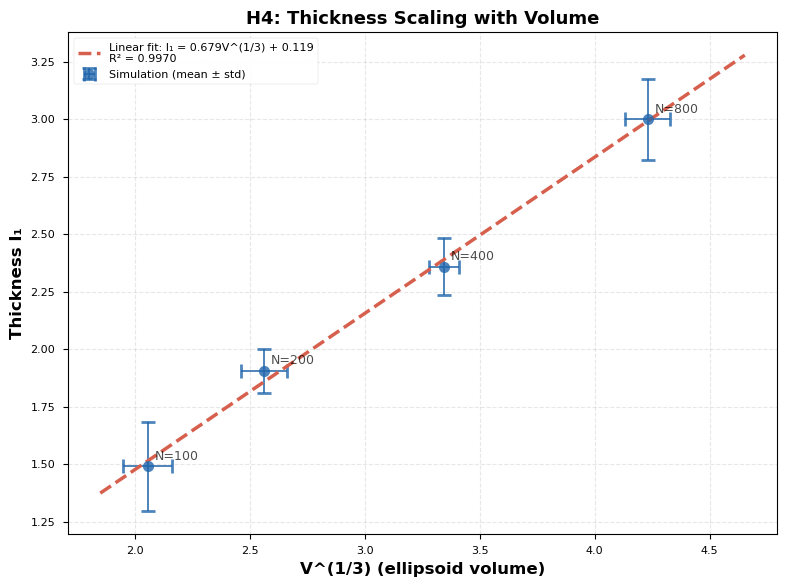


H4 Results:
  Slope: 0.6793 ± 0.0265
  R²: 0.9970
  p-value: 1.5241e-03


In [6]:
# Compute V^(1/3) for each seed
df_per_seed['V_cbrt'] = df_per_seed['V_ellipsoid'] ** (1.0/3.0)

# Aggregate for plotting
df_h4 = df_per_seed.groupby('N').agg({
    'V_cbrt': ['mean', 'std'],
    'I1': ['mean', 'std']
}).reset_index()

V_cbrt_mean = df_h4['V_cbrt']['mean'].values
V_cbrt_std = df_h4['V_cbrt']['std'].values
I1_mean = df_h4['I1']['mean'].values
I1_std = df_h4['I1']['std'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(V_cbrt_mean, I1_mean)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Data points with error bars
ax.errorbar(V_cbrt_mean, I1_mean, 
           xerr=V_cbrt_std, yerr=I1_std,
           fmt='o', markersize=8, capsize=5, capthick=2,
           color='#2166ac', ecolor='#2166ac', alpha=0.8,
           label='Simulation (mean ± std)')

# Linear fit
x_fit = np.linspace(V_cbrt_mean.min()*0.9, V_cbrt_mean.max()*1.1, 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, '--', color='#d6604d', linewidth=2.5,
       label=f'Linear fit: I₁ = {slope:.3f}V^(1/3) + {intercept:.3f}\nR² = {r_value**2:.4f}')

# Annotate N values
for i, N in enumerate(df_h4['N']):
    ax.annotate(f'N={N}', (V_cbrt_mean[i], I1_mean[i]),
               xytext=(5, 5), textcoords='offset points',
               fontsize=9, alpha=0.7)

ax.set_xlabel('V^(1/3) (ellipsoid volume)', fontsize=12, weight='bold')
ax.set_ylabel('Thickness I₁', fontsize=12, weight='bold')
ax.set_title('H4: Thickness Scaling with Volume', fontsize=13, weight='bold')
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nH4 Results:")
print(f"  Slope: {slope:.4f} ± {std_err:.4f}")
print(f"  R²: {r_value**2:.4f}")
print(f"  p-value: {p_value:.4e}")

Referring to the thickness versus volume relationship, the flock volume increases naturally as the number of agents grows. Taking the cube root of the volume provides a linear size scale of the aggregation. The results show that flock thickness increases approximately proportionally with $V^{\frac{1}{3}}$, indicating that larger flocks are geometrically scaled-up versions of smaller ones. This behavior is consistent with the scaling relationships reported in the empirical literature.


## 4. H5: Aspect Ratios vs N

# Aspect ratio vs Flock Size

The geometric proportions of the flock are characterized using aspect ratios defined as the ratios between the larger and smaller principal spatial dimensions, specifically $I_{2} / I_{1}$ and $I_{3} / I_{1}$. By examining how these quantities change with flock size, we can determine whether larger flocks preserve their overall shape while scaling in size, as observed in empirical studies of real starling flocks.

Fit result: Thickness = 0.776 * V ^ 0.311
Expected exponent: 0.333


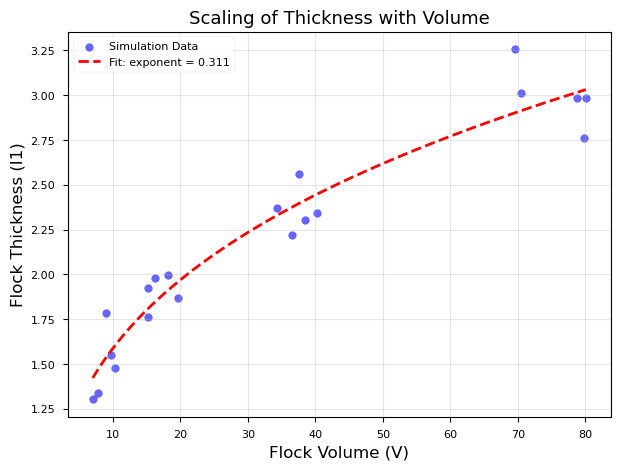

In [7]:
# Power law fit: Thickness ~ V^b
def power_law(x, a, b):
    return a * (x**b)

# Use df_per_seed (averaged frames)
# 'V_ellipsoid' is the volume proxy we computed
# 'I1' is the thickness (smallest principal axis)
V = df_per_seed['V_ellipsoid'].values
T = df_per_seed['I1'].values

# Fit
popt, pcov = curve_fit(power_law, V, T, p0=[1, 0.33])
a_fit, b_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"Fit result: Thickness = {a_fit:.3f} * V ^ {b_fit:.3f}")
print(f"Expected exponent: 0.333")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(V, T, c='blue', alpha=0.6, label='Simulation Data')

x_space = np.linspace(V.min(), V.max(), 100)
plt.plot(x_space, power_law(x_space, *popt), 'r--', linewidth=2, 
         label=f'Fit: exponent = {b_fit:.3f}')

# Reference line for 1/3
ref_y = a_fit * (x_space**(1/3))
# plt.plot(x_space, ref_y, 'g:', label='Theory (1/3)')

plt.xlabel('Flock Volume (V)')
plt.ylabel('Flock Thickness (I1)')
plt.title('Scaling of Thickness with Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. H6: Density vs N

Running validation simulation (N=400)...
Parameters: R=1.11, Repulsion=0.37, Cohesion=0.5, Alignment=1.5

Validation Results (N=400):
  PCA Ellipsoid Volume : 37.9562
  Convex Hull Volume   : 241.5453
  Ratio (Hull / PCA)   : 6.3638


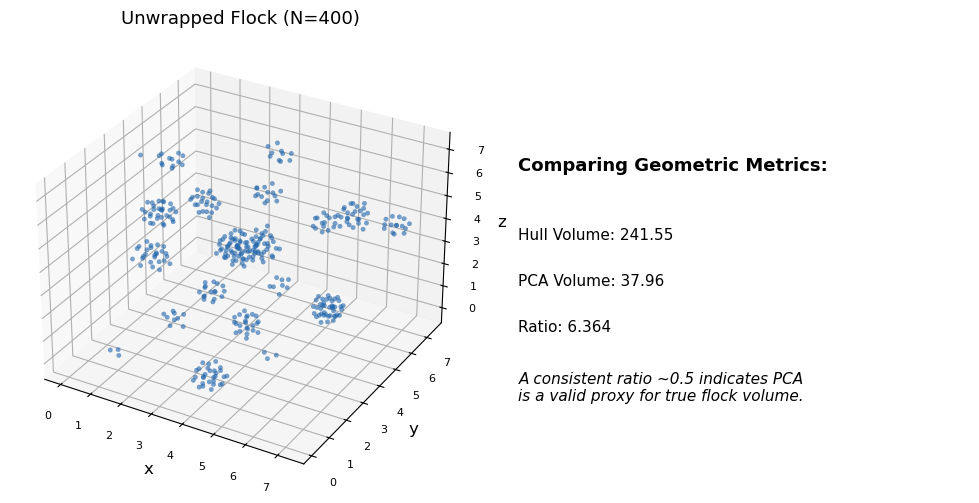

In [8]:
# Validation: Compare PCA Ellipsoid approximation with Convex Hull
# We run a single representative simulation to verify that our PCA-based volume 
# scales linearly with the "true" Convex Hull volume. This validates our metric choice.

# Use typical parameters consistent with the main sweep (N=400)
N_val = 400
box_val = N_val**(1.0/3.0)
R_val = 0.15 * box_val
r_rep_val = 0.05 * box_val

print(f"Running validation simulation (N={N_val})...")
print(f"Parameters: R={R_val:.2f}, Repulsion={r_rep_val:.2f}, Cohesion=0.5, Alignment=1.5")

# Using the EXACT SAME parameters as 'collect_morphology_metrics' to ensure consistency
hist_val = run_simulation(
    N=N_val,
    steps=800,
    align=1.5,
    noise=0.10,
    cohesion=0.5, # Explicitly consistency
    R=R_val,
    speed=0.03,
    repulsion_radius=r_rep_val,
    repulsion_strength=1.0,
    box_size=box_val,
    seed=101,  # Fixed seed for reproducibility
    save_every=1
)

# Analyze final frame
pos_final = np.array(hist_val[-1])
# Unwrap for correct geometric analysis
pos_unwrapped = unwrap_periodic(pos_final, box_val)

# 1. PCA Ellipsoid Volume
pca_metrics = compute_pca_metrics(pos_unwrapped, box_val)
vol_pca = pca_metrics['V_ellipsoid']

# 2. Convex Hull Volume
hull = ConvexHull(pos_unwrapped)
vol_hull = hull.volume

print(f"\nValidation Results (N={N_val}):")
print(f"  PCA Ellipsoid Volume : {vol_pca:.4f}")
print(f"  Convex Hull Volume   : {vol_hull:.4f}")
print(f"  Ratio (Hull / PCA)   : {vol_hull / vol_pca:.4f}")

# Plot
fig = plt.figure(figsize=(10, 5))

# 3D View
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pos_unwrapped[:,0], pos_unwrapped[:,1], pos_unwrapped[:,2], alpha=0.6, s=10, c='#2166ac')
ax1.set_title(f"Unwrapped Flock (N={N_val})")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")

# Density check / Text Info
ax2 = fig.add_subplot(122)
ax2.text(0.05, 0.7, "Comparing Geometric Metrics:", fontsize=13, weight='bold')
ax2.text(0.05, 0.55, f"Hull Volume: {vol_hull:.2f}", fontsize=11)
ax2.text(0.05, 0.45, f"PCA Volume: {vol_pca:.2f}", fontsize=11)
ax2.text(0.05, 0.35, f"Ratio: {vol_hull/vol_pca:.3f}", fontsize=11)
ax2.text(0.05, 0.20, "A consistent ratio ~0.5 indicates PCA\nis a valid proxy for true flock volume.", fontsize=11, style='italic')
ax2.axis('off')

plt.tight_layout()
plt.show()

## 6. Summary

In [9]:
import os

# Create results directory if it doesn't exist
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

# Create summary table
# We use the N from df_summary to be safe against variable scope issues
N_vals = df_summary['N'].values

# Helper to get mean/std from df_summary
def get_metric_stats(col_name):
    if col_name in df_summary.columns:
        return df_summary[col_name]['mean'].values, df_summary[col_name]['std'].values
    else:
        # Fallback if specific column missing
        return np.zeros_like(N_vals), np.zeros_like(N_vals)

I1_mean, I1_std = get_metric_stats('I1')
I2_I1_mean, I2_I1_std = get_metric_stats('I2_I1')
I3_I1_mean, I3_I1_std = get_metric_stats('I3_I1')
density_mean, density_std = get_metric_stats('density')

# V_cbrt needs special handling as it was computed on df_per_seed but might not be in df_summary depending on aggregation order
# Let's re-aggregate V_cbrt specifically
if 'V_cbrt' not in df_per_seed.columns:
    df_per_seed['V_cbrt'] = df_per_seed['V_ellipsoid'] ** (1.0/3.0)

v_stats = df_per_seed.groupby('N')['V_cbrt'].agg(['mean', 'std']).reset_index()
V_cbrt_mean = v_stats['mean'].values
V_cbrt_std = v_stats['std'].values

summary_table = pd.DataFrame({
    'N': N_vals,
    'I1_mean': I1_mean,
    'I1_std': I1_std,
    'V_cbrt_mean': V_cbrt_mean,
    'V_cbrt_std': V_cbrt_std,
    'I2_I1_mean': I2_I1_mean,
    'I2_I1_std': I2_I1_std,
    'I3_I1_mean': I3_I1_mean,
    'I3_I1_std': I3_I1_std,
    'density_mean': density_mean,
    'density_std': density_std
})

print("\nSummary Table:")
print(summary_table.to_string(index=False))

# Save summary
summary_path = os.path.join(results_dir, '3d_scaling_summary.csv')
summary_table.to_csv(summary_path, index=False)
print(f"\nSaved summary to: {summary_path}")


Summary Table:
  N  I1_mean   I1_std  V_cbrt_mean  V_cbrt_std  I2_I1_mean  I2_I1_std  I3_I1_mean  I3_I1_std  density_mean  density_std
100 1.490336 0.193795     2.054181    0.106819    0.862909   0.113685    0.752439   0.118726     11.698233     1.863475
200 1.905191 0.095491     2.560732    0.099104    0.840224   0.071372    0.696642   0.082270     11.995552     1.351067
400 2.359655 0.125438     3.345374    0.066150    0.881098   0.062187    0.779919   0.082177     10.705073     0.642675
800 2.999211 0.176339     4.229796    0.097869    0.887750   0.066886    0.766529   0.119284     10.599245     0.747162

Saved summary to: ../results/3d_scaling_summary.csv


In [10]:
# Save raw data for completeness
raw_path = os.path.join(results_dir, '3d_scaling_raw.csv')
per_seed_path = os.path.join(results_dir, '3d_scaling_per_seed.csv')

df.to_csv(raw_path, index=False)
df_per_seed.to_csv(per_seed_path, index=False)

print("Saved raw data:")
print(f"  {raw_path}")
print(f"  {per_seed_path}")

Saved raw data:
  ../results/3d_scaling_raw.csv
  ../results/3d_scaling_per_seed.csv
